# Autoreload

In [37]:
%reload_ext autoreload
%autoreload 2

# Load libraries and packages

In [38]:
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Utility function

In [39]:
from utils import clean_text, DenseTransformer

# Load data

In [40]:

dt = pd.read_csv('imdb_labelled.txt', delimiter = '\t', names=["reviews", "rating"])
dt.head(5)

,reviews,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


# Create labels

In [41]:

dt['labels'] = movie["rating"].apply(lambda x: "Positive" if x else "Negative")
dt.head()

,reviews,rating,labels
0,"A very, very, very slow-moving, aimless movie ...",0,Negative
1,Not sure who was more lost - the flat characte...,0,Negative
2,Attempting artiness with black & white and cle...,0,Negative
3,Very little music or anything to speak of.,0,Negative
4,The best scene in the movie was when Gerardo i...,1,Positive


# Missing values

In [42]:
dt.isnull().sum()

reviews    0
rating     0
labels     0
dtype: int64

# Create length of each document

In [43]:
dt['length'] = movie['reviews'].apply(lambda x: len(str(x).split(' ')))
dt.head()

,reviews,rating,labels,length
0,"A very, very, very slow-moving, aimless movie ...",0,Negative,15
1,Not sure who was more lost - the flat characte...,0,Negative,21
2,Attempting artiness with black & white and cle...,0,Negative,33
3,Very little music or anything to speak of.,0,Negative,10
4,The best scene in the movie was when Gerardo i...,1,Positive,23


In [44]:
dt['length'].unique()


array([  15,   21,   33,   10,   23,   22,    5,   17,   12,    8,   13,
          6,   18,   25,   19,  868,   14,   16,    9,    7,   26,   35,
         11,    4,   27,   28,    3,   20,   37,   24,   36,  201, 1393,
         49,   30,  306,   31,   32,   44,   56,   45,   34,   38,   64,
         58,   40,   47,   29,   73,   41,   39,   55,   53,   42,  800],
      dtype=int64)

# Label frequency

1    386
0    362
Name: rating, dtype: int64



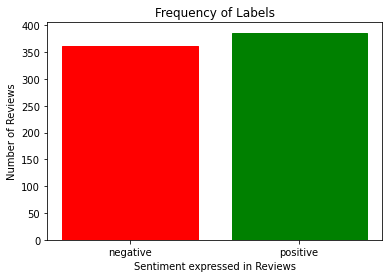

In [45]:

Index = [1, 0]

print(dt["rating"].value_counts())
print()

barlist = plt.bar(Index, dt["labels"].value_counts())

plt.title("Frequency of Labels")
plt.xticks(Index, ['positive', 'negative'])
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment expressed in Reviews')

barlist[Index[1]].set_color('green')
barlist[Index[0]].set_color('red')
plt.show()

# Since we can observed from the above graph that the data is balance there will be no need to before SMOOT on it to balance the data

<BarContainer object of 55 artists>

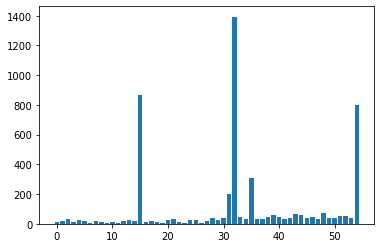

In [46]:
unique_lengths = dt['length'].unique()
plt.bar(np.arange(len(unique_lengths)), unique_lengths)

# Apply clean text into the data for cleansing

In [47]:

dt['clean review'] = dt['reviews'].apply(clean_text)
dt.head()

,reviews,rating,labels,length,clean review
0,"A very, very, very slow-moving, aimless movie ...",0,Negative,15,a very very very slowmoving aimless movie abou...
1,Not sure who was more lost - the flat characte...,0,Negative,21,not sure who wa more lost the flat character o...
2,Attempting artiness with black & white and cle...,0,Negative,33,attempting artiness with black white and cleve...
3,Very little music or anything to speak of.,0,Negative,10,very little music or anything to speak of
4,The best scene in the movie was when Gerardo i...,1,Positive,23,the best scene in the movie wa when gerardo is...


In [48]:
X = dt['reviews']
y = dt['rating']

# Test preprocessing

Splitting data set into train andtest 60%, 40% respectively

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .40, random_state = 60)

In [50]:
print(f' train shape of output:{X_train.shape}, output: {y_test.shape}')
print(f' test of shape of{X_test.shape}, output:{y_test.shape}' )

 train shape of output:(448,), output: (300,)
 test of shape of(300,), output:(300,)


# Train and preprocess text using count vectorizer

In [51]:
cv_nb = Pipeline([
    ('Bag_of_words', CountVectorizer(stop_words = 'english')), 
    ('classifier', MultinomialNB()),
])

In [52]:
cv_nb.fit(X_train, y_train)


Pipeline(steps=[('Bag_of_words', CountVectorizer(stop_words='english')),
                ('classifier', MultinomialNB())])

In [53]:
joblib.dump(cv_nb, "models/multinomial_naive_bayes_with_count_vectorizer.joblib")


['models/multinomial_naive_bayes_with_count_vectorizer.joblib']

In [54]:
model_pred = cv_nb.predict(X_test)


In [55]:
print(classification_report(y_test, model_pred))


              precision    recall  f1-score   support

           0       0.81      0.66      0.73       155
           1       0.70      0.83      0.76       145

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300



# Running Cross validation with Countvectorizer and MultinomialNB

In [56]:
accurancy = []
stratifiedKf_predict = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
stratifiedKf_predict.get_n_splits(X,y)

for train_index, test_index in stratifiedKf_predict.split(X,y):
   
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
  
    cv_nb.fit(X1_train, y1_train)
    result = cv_nb.score(X1_test, y1_test)
    accurancy.append(result)

accuracy = np.array(accurancy)

#Print the output
print('list of first 10 possible accurancy:')

for index, acc in enumerate(accuracy[:10]):
    print(f' {index+1:3d}. {acc:.4f}')


print('\nMetrics that were obtained from this model:')
print(f' Maximum Accurancy: {accuracy.max()*100:.2f}%')
print(f' Minimum Accurancy: {accuracy.min()*100:.2f}%')
print(f' Mean Accurancy: {accuracy.mean()*100:.2}%')
print(f' Std accurancy: {accuracy.std()*100:.2f}%')
print(accurancy)

list of first 10 possible accurancy:
   1. 0.7467
   2. 0.7667
   3. 0.7067
   4. 0.7785
   5. 0.7450

Metrics that were obtained from this model:
 Maximum Accurancy: 77.85%
 Minimum Accurancy: 70.67%
 Mean Accurancy: 7.5e+01%
 Std accurancy: 2.45%
[0.7466666666666667, 0.7666666666666667, 0.7066666666666667, 0.7785234899328859, 0.7449664429530202]


# Training with count Vectorizer and Multinomial NB

In [57]:
tfidf_nb = Pipeline([
    ('Term_freq', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])

In [59]:
tfidf_nb.fit(X_train, y_train)

Pipeline(steps=[('Term_freq', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [60]:
joblib.dump(cv_nb, "models/multinomial_naive_bayes_with_Tfidf_vectorizer.joblib")

['models/multinomial_naive_bayes_with_Tfidf_vectorizer.joblib']

In [63]:
model_pred = tfidf_nb.predict(X_test)

In [64]:
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       155
           1       0.70      0.88      0.78       145

    accuracy                           0.76       300
   macro avg       0.77      0.76      0.75       300
weighted avg       0.78      0.76      0.75       300



## Runing cross validation with Tfidf with Multinomial NB

In [65]:
accurancy = []

stratifiedKf_predict = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
stratifiedKf_predict.get_n_splits(X,y)

for train_index, test_index in stratifiedKf_predict.split(X,y):
   
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
  
    tfidf_nb.fit(X1_train, y1_train)
    result = tfidf_nb.score(X1_test, y1_test)
    accurancy.append(result)

accuracy = np.array(accurancy)

# print the ouput
print('list of first 10 possible accurancy')
for index, acc in enumerate(accuracy[:10]):
    print(f"{index+1:3d}. {acc:.4f}")

    
print('\nMetrics that were obtain from the model:')
print(f' Maximum accuracy: {accuracy.max()*100:.2f}%')
print(f' Minimum Accuracy: {accuracy.min()*100:.2f}%')
print(f' Mean_accuracy: {accuracy.mean()*100:.2f}%')
print(f' Std_accuracy: {accuracy.std()*100:.2f}%')

print(accurancy)

list of first 10 possible accurancy
  1. 0.7667
  2. 0.7733
  3. 0.8000
  4. 0.8255
  5. 0.7517

Metrics that were obtain from the model:
 Maximum accuracy: 82.55%
 Minimum Accuracy: 75.17%
 Mean_accuracy: 78.34%
 Std_accuracy: 2.62%
[0.7666666666666667, 0.7733333333333333, 0.8, 0.825503355704698, 0.7516778523489933]


In [66]:
!pip freeze>requirements.txt

In [67]:
!pip freeze nltk

argon2-cffi==20.1.0
async-generator==1.10
attrs==20.2.0
backcall==0.2.0
bleach==3.2.1
certifi==2020.6.20
cffi==1.14.3
click==7.1.2
colorama==0.4.4
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
importlib-metadata==2.0.0
ipykernel==5.3.4
ipython==7.18.1
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.17.2
Jinja2==2.11.2
joblib==0.17.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.7
jupyter-console==6.2.0
jupyter-core==4.6.3
jupyterlab-pygments==0.1.2
kiwisolver==1.2.0
MarkupSafe==1.1.1
matplotlib==3.3.2
mistune==0.8.4
nbclient==0.5.1
nbconvert==6.0.7
nbformat==5.0.8
nest-asyncio==1.4.1
nltk==3.5
notebook==6.1.4
numpy==1.19.2
packaging==20.4
pandas==1.1.3
pandocfilters==1.4.2
parso==0.7.1
pickleshare==0.7.5
Pillow==8.0.0
prometheus-client==0.8.0
prompt-toolkit==3.0.8
pycparser==2.20
Pygments==2.7.1
pyparsing==2.4.7
pyrsistent==0.17.3
python-dateutil==2.8.1
pytz==2020.1
pywin32==228
pywinpty==0.5.7
pyzmq==19.0.2
qtconsole==4.7.7
QtPy==1.9.0
regex==2020.10.15
s